# **Lezione 9**
### **Il problema del commesso viaggiatore (TSP)**
il TSP è un problema matematico che consiste nel trovare il percorso più breve che un commesso viaggiatore può seguire per visitare un certo numero di città N, e tornare al punto di partenza, visitando ogni città una sola volta. Visualizzo ciascun percorso come un vettore unidimensionale di interi che rappresenta l'ordine di visita delle città:

$$ percorso =[1,3,4,2,5,...,N]$$

dove ciascun numero indica l’indice della città nella sequenza di visita, ogni città viene visitata una sola volta e l'indice di partenza è sempre la città numero 1.
<br>La loss function associata a ogni percorso rappresenta la lunghezza totale dell'itinerario chiuso. La scelta era fra due diverse funzioni:

$$
L^{(2)}(\vec{x_1},\vec{x_2}, ..., \vec{x_N}) = \sum_{i=1}^N |\vec{x}_i-\vec{x}_{i+1}|^2 
\hspace{2cm} 
L^{(1)}(\vec{x_1},\vec{x_2}, ..., \vec{x_N}) = \sum_{i=1}^N |\vec{x}_i-\vec{x}_{i+1}| 
$$

Tra le due ho scelto di proseguire con $L^{(1)}$ ossia la somma delle distanze euclidee tra città consecutive nel percorso (incluso il ritorno all’origine $\vec{x}_{N+1} = \vec{x}_{1}$ per chiudere il ciclo).

Per risolvere questo problema di ottimizzazione, utilizzeremo un algoritmo genetico (GA) che imita il processo di selezione naturale. L'algoritmo parte da una popolazione di individui (possibili soluzioni al problema) e li fa evolvere attraverso nuove generazioni, applicando operatori genetici come mutazione e crossover, al fine di trovare la soluzione migliore al problema.

### **Struttura del codice**
Per implementare il mio algoritmo genetico per il problema del commesso viaggiatore (TSP), ho strutturato il codice in modo modulare e riutilizzabile, sfruttando la struttura a classi. 

##### **File di input**
Tutti i parametri di simulazione vengono letti da un file di input chiamato `sim_parameters.dat`. Questa scelta permette di modificare facilmente le condizioni della simulazione senza dover ricompilare il codice. Il file è organizzato come segue:

>NCITTA $\hspace{2.3cm} $ 34
<br> NINDIVIDUI $\hspace{1.6cm} $ 100
<br>NGENERATIONS $\hspace{0.7cm} $ 500
<br>NOMEFILEIN $\hspace{1.35cm} $ circular_path.txt

Questa funzionalità è stata utile anche nella lezione successiva, dove nell'implementazione ho fatto minime modifiche alla struttura.

##### **La classe percorso**
Il programma è costituito da due classi; la prima è la classe <i>percorso</i>. Essa rappresenta un singolo individuo della popolazione, ovvero un possibile tragitto che attraversa tutte le città.
I data member privati della classe sono:
```cpp
   int n_city;          // ➙ numero delle città passato dal file di input
   vector<int> path;    // ➙ la sequenza di città del percorso
   Random* rnd;         // ➙ generatore di numeri casuali passato dalla classe generazione
   static vector<vector<double>> matrice_distanze;
```
La definizione della matrice delle distanze come "static" è molto comoda in questo caso, perché non appartiene ad un singolo percorso, ma è condivisa da tutte le istanze della classe. In questo modo si evitano molteplici copie della variabile, ne esiste solo una, indipendentemente da quanti oggetti percorso sono creati.

Tra i membri pubblici troviamo invece i metodi per:
   - accedere o modificare i membri privati
   - calcolare la lunghezza del percorso con `get_lenght()`
   - effettuare mutazioni (simili a quelle che avvengono negli alleli di un cromosoma):
   ```cpp
      void pair_swap();          // ➙ cambia la posizione di due città a caso 
      void shift();              // ➙ sposta ciclicamente (con pbc) le città di m posti
      void block_inversion();    // ➙ definito un blocco grande m posti, inverte l'odine delle città contenute
      void block_permutation();  // ➙ definito un blocco grande m posti, scambia n volte due città a caso del blocco
      void multiple_mutation();  // ➙ permette casualmente più mutazioni tra quelle sopra
      void single_mutation();    // ➙ permette casualmente una sola mutazione tra quelle sopra
   ```
   - controllare se i percorsi rispettano i vincoli inposti dal problema (`bounds_control()`), ossia che la città di partenza sia la #1 e che ogni città sia visitata una sola volta


##### **La classe generazione**

La seconda classe del programma è *generazione*, che rappresenta l'intera popolazione di percorsi. Questa classe si occupa della gestione evolutiva della popolazione secondo i principi dell’algoritmo genetico: selezione, crossover e mutazione.

Tra i membri privati, troviamo:
```cpp
int n_city;           // ➙ numero di città 
int n_individui;      // ➙ numero di individui nella generazione
vector<percorso> individui; // ➙ popolazione
Random rnd;           // ➙ generatore di numeri casuali locale
int rank;             // ➙ ID del processo (per parallelizzazione Lez10)
```
I metodi pubblici permettono di:
   - accedere a informazioni come il numero di individui e città;
   - ordinare la popolazione in base alla fitness (lunghezza del percorso) con `ordina()`;
   - ottenere e modificare singoli percorsi, tra cui `get_best()` che restituisce il miglior individuo;
   - effettuare una totale ricombinazione genetica della popolazione con `order_crossover()` :
      <br>Si occupa di generare una nuova popolazione di percorsi a partire da quella esistente. Ordinata la popolazione, vengono selezionate le coppie di genitori in maniera probabilistica, favorendo gli migliori. Ogni coppia può accoppiarsi (90%) e generare due figli, oppure venir copiata nella nuova genereazione immutata (10%). Nel primo caso, viene scelto un punto di taglio casuale: i primi geni vengono copiati direttamente da ciascun genitore, mentre il resto del percorso viene completato rispettando l’ordine delle città dell’altro genitore. Al termine del processo, se la popolazione ha un numero dispari di individui, il miglior percorso viene copiato per riempire l’ultimo posto.

   - applicare mutazioni su tutta la popolazione con `global_mutation()`;
   - calcolare la distanza media di metà campione con `avarage_distance()`;



##### **Il main**

Il cuore dell’algoritmo è racchiuso nel main. Dopo aver letto dal file di input `sim_parameters.dat` il numero di città, il numero di individui nella popolazione, il numero di generazioni e il file contenente le coordinate delle città, il programma seleziona i file di output, in modo da mantenere ordinati e separati i risultati per ciascun tipo di simulazione.

Successivamente, vengono lette le coordinate delle città dal file scelto e viene calcolata la matrice delle distanze tra tutte le coppie di città. Questa matrice viene poi passata alla classe percorso come membro static, rendendola condivisa da tutti gli individui.

Infine, viene creata una generazione, che gestisce l’evoluzione dell'intera popolazione e qui inizia il vero algoritmo genetico:
```cpp
   for (int gen = 0; gen < n_generazioni; gen++) {
      pop.global_mutation();
      pop.order_crossover();
      L1 << gen + 1 << "\t" << pop.get_best().get_lenght() << "\t" << pop.average_distance() << endl;
   }
```
 Per ogni generazione, si applicano mutazioni e crossover e si registrano su file sia la lunghezza del miglior percorso trovato, sia la lunghezza media della popolazione. Al termine della simulazione, il miglior percorso individuato viene salvato in un file di output dedicato.


### **Risultati**
L’algoritmo genetico è stato applicato al problema del commesso viaggiatore per due configurazioni di città: una disposta su una circonferenza e una distribuita casualmente in un quadrato. Nei grafici presentati, si confronta il percorso iniziale (alla generazione 1) con il miglior percorso trovato alla generazione 500. In entrambe le configurazioni il percorso iniziale è altamente inefficiente, con numerosi incroci e deviazioni. Dopo 500 generazioni, il miglior percorso ottenuto mostra invece una struttura molto più efficiente, senza incroci. Mentre per il cerchio è facile verificare che il percorso raggiunto è effettivamente il migliore, per quella randomica non siamo in grado di stabilire se quello trovato è il minimo assoluto tra tutti i percorsi. 

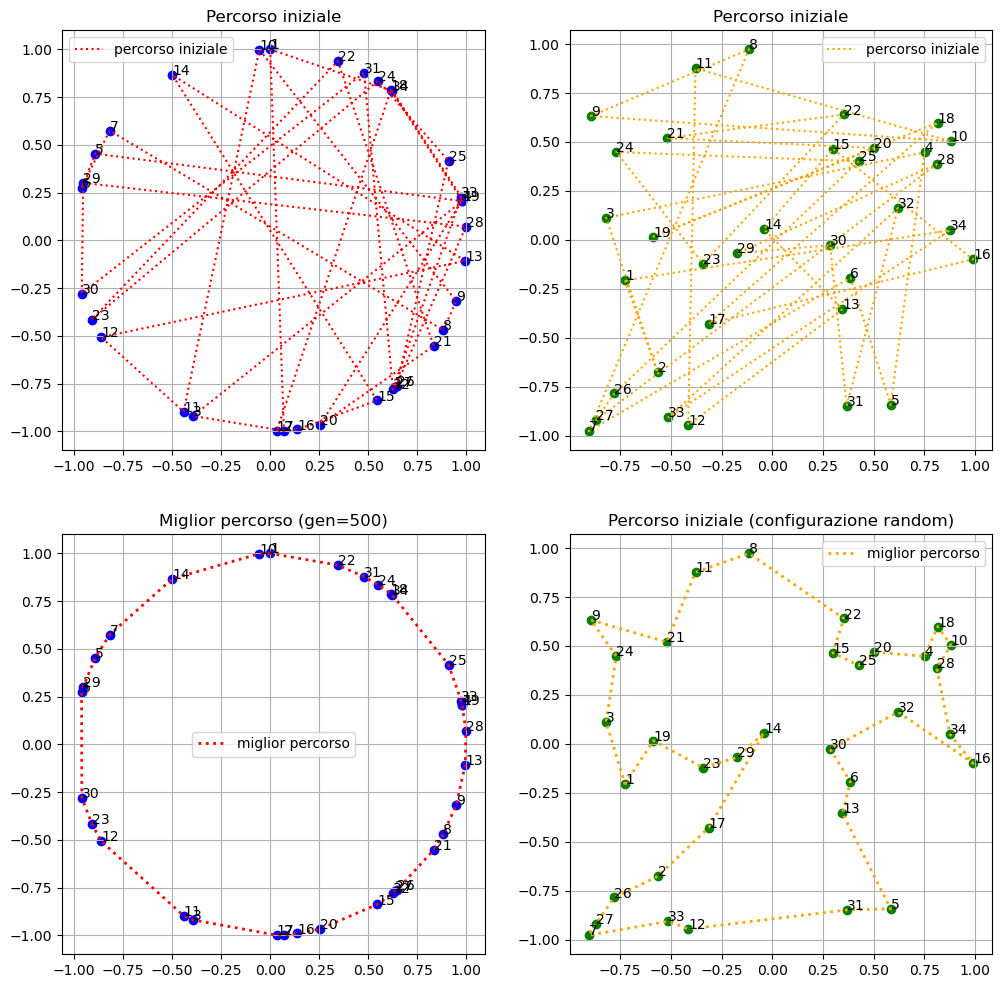

In [5]:
import numpy as np
import matplotlib.pyplot as plt

# ======= Percorso migliore ======= #

id, x1, y1 = np.loadtxt('CONFIGS/circular_path.txt', delimiter="\t", unpack=True)
id, x2, y2 = np.loadtxt('CONFIGS/random_path.txt', delimiter="\t", unpack=True)
n_city = len(id)

circ_path = np.loadtxt("OUTPUT/best_circ.dat")
circ_path = np.append(circ_path, 1)
rand_path = np.loadtxt("OUTPUT/best_rand.dat")
rand_path = np.append(rand_path, 1)

ordine = []
for cid in circ_path:
    for i, city_id in enumerate(id):
        if city_id == cid:
            ordine.append(i)
            break
# coordinate riordinate come me lo dice il percorso migliore
x_circ = x1[ordine]
y_circ = y1[ordine]

ordine = [] 
for cid in rand_path:
    for i, city_id in enumerate(id):
        if city_id == cid:
            ordine.append(i) 
            break
x_rand = x2[ordine]
y_rand = y2[ordine]

# ======= Percorso iniziale ======= #

initial_order = np.argsort(id)  # ordina le città per ID
x_init_circ = x1[initial_order]
y_init_circ = y1[initial_order]
x_init_rand = x2[initial_order]
y_init_rand = y2[initial_order]

# chiudi il percorso
x_init_circ = np.append(x_init_circ, x_init_circ[0])
y_init_circ = np.append(y_init_circ, y_init_circ[0])
x_init_rand = np.append(x_init_rand, x_init_rand[0])
y_init_rand = np.append(y_init_rand, y_init_rand[0])

fig, axes = plt.subplots(2, 2, figsize=(12, 12))

for i in range(n_city):
    axes[0,0].text(x1[i], y1[i], str(int(id[i])), fontsize=10)
    axes[1,0].text(x1[i], y1[i], str(int(id[i])), fontsize=10)
    axes[0,1].text(x2[i], y2[i], str(int(id[i])), fontsize=10)
    axes[1,1].text(x2[i], y2[i], str(int(id[i])), fontsize=10)


axes[0,0].scatter(x1, y1, color='blue')
axes[0,0].plot(x_init_circ, y_init_circ, color='red', linestyle=':', label='percorso iniziale')
axes[0,0].set_title("Percorso iniziale")
axes[0,0].legend()
axes[0,0].grid(True)


axes[1,0].scatter(x1, y1, color='blue')
axes[1,0].plot(x_circ, y_circ, color='red', linestyle = ":", linewidth=2, label='miglior percorso')
axes[1,0].set_title("Miglior percorso (gen=500)")
axes[1,0].legend()
axes[1,0].grid(True)

axes[0,1].scatter(x2, y2, color='green')
axes[0,1].plot(x_init_rand, y_init_rand, color='orange', linestyle=':', label='percorso iniziale')
axes[0,1].set_title("Percorso iniziale")
axes[0,1].legend()
axes[0,1].grid(True)

axes[1,1].scatter(x2, y2, color='green')
axes[1,1].plot(x_rand, y_rand, color='orange', linestyle = ":", linewidth=2, label='miglior percorso')
axes[1,1].set_title("Percorso iniziale (configurazione random)")
axes[1,1].legend()
axes[1,1].grid(True)

plt.show()


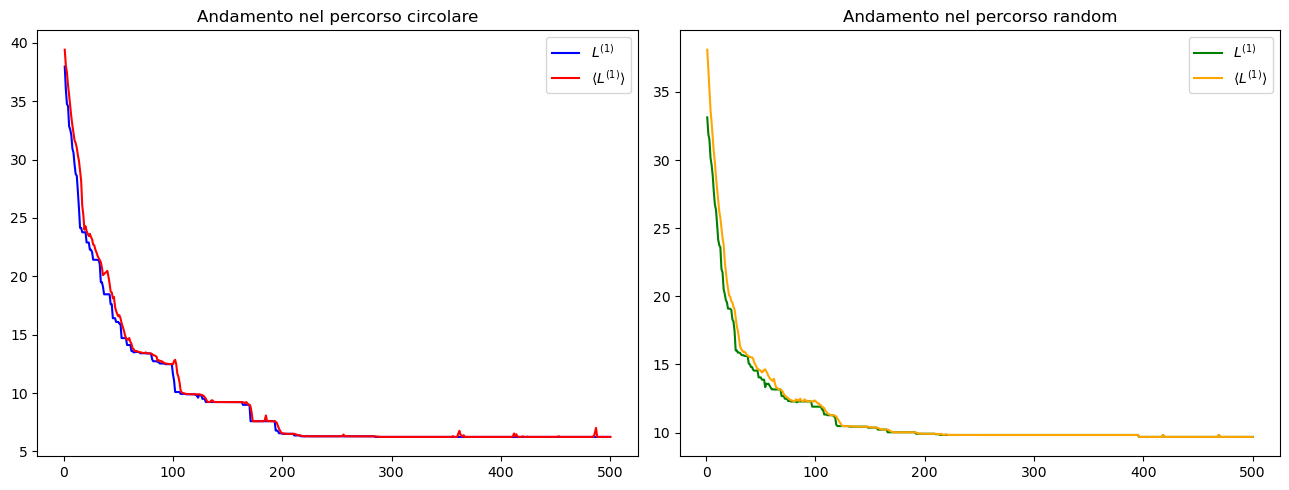

Lunghezza del miglior percorso circolare:  6.24605
Lunghezza del miglior percorso random:  9.67772


In [6]:
import numpy as np
import matplotlib.pyplot as plt

gens_c, L1_c, L1av_c = np.loadtxt("OUTPUT/L1_circ.dat", delimiter="\t", unpack=True)
gens_r, L1_r, L1av_r = np.loadtxt("OUTPUT/L1_rand.dat", delimiter="\t", unpack=True)

fig, axes = plt.subplots(1, 2, figsize=(13, 5))
axes[0].plot(gens_c, L1_c, color='blue', label=r"$ L^{(1)}$")
axes[0].set_title(r"Andamento nel percorso circolare")
axes[0].plot(gens_c, L1av_c, color='red', label=r"$\langle L^{(1)}  \rangle$")
axes[0].legend()
axes[1].plot(gens_r, L1_r, color='green', label=r"$ L^{(1)}$")
axes[1].set_title(r"Andamento nel percorso random")
axes[1].plot(gens_r, L1av_r, color='orange', label=r"$\langle  L^{(1)}  \rangle$")
axes[1].legend()
plt.tight_layout()
plt.show()

print("Lunghezza del miglior percorso circolare: ", L1_c[-1])
print("Lunghezza del miglior percorso random: ", L1_r[-1])



Oltre al confronto visivo dei percorsi, sono stati tracciati i grafici dell’evoluzione temporale della distanza $L^{(1)}$ del percorso migliore trovato in ogni generazione e della distanza media $\langle L^{(1)} \rangle $ calcolata sulla metà migliore della popolazione. 
<br>In entrambi i casi, si osserva un comportamento coerente e convergente: la media segue da vicino l’andamento della distanza minima, segno che l’intera popolazione evolve verso soluzioni più corte, e non solo pochi individui. Ciò è indicativo di una buona pressione selettiva: la popolazione esplora lo spazio delle soluzioni in modo discriminatorio, portando a una convergenza stabile già intorno alla $300^a-400^a$ generazione.